In [20]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, Account, BlockNumber, Records, JoinType
from models.credmark.protocols.dexes.uniswap.univ3_math import tick_to_price, sqrt_price_x_96_to_price, tick_to_sqrt_price_x_96, sqrt_price_x_96_to_tick
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def plot_scatter_with_regression(x, y, title):
    # Perform linear regression
    regression_model = LinearRegression()
    regression_model.fit(x.reshape(-1, 1), y)
    r_squared = regression_model.score(x.reshape(-1, 1), y)

    # Create scatter plot
    plt.scatter(x, y, color='blue', label='Data Points')

    # Plot the linear regression line
    plt.plot(x, regression_model.predict(x.reshape(-1, 1)), color='red', label='Linear Regression')

    # Display the linear regression formula and R-squared value
    formula = f'y = {regression_model.coef_[0]:.2f}x + {regression_model.intercept_:.2f}'
    plt.text(1, np.max(y), formula, fontsize=10)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Scatter Plot with Linear Regression {title}')
    plt.legend(loc='lower right')
    plt.grid()

    plt.show()


cmf_param = {
    'chain_id': 1,
    'block_number': 18_433_111,  # Remove this line to use the latest block
}

context, _model_loader = create_cmf(cmf_param)

In [4]:
df_weth_usdc = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0x8ad599c3A0ff1De082011EFDDc58f1908eb6e6D8", "startBlock": 15_033_111, "interval": 100_000})['results'])

df_weth_usdt = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0x4e68Ccd3E89f51C3074ca5072bbAC773960dFa36", "startBlock": 15_033_111, "interval": 100_000})['results'])

df_weth_dai = pd.DataFrame(context.run_model(
    'pool.dex-lvr',
    {"address": "0xC2e9F25Be6257c210d7Adf0D4Cd6E3E881ba25f8", "startBlock": 15_033_111, "interval": 100_000})['results'])

In [23]:
df_weth_usdc.columns

Index(['to_block', 'token0_in', 'token1_in', 'from_block', 'token0_out',
       'token1_out', 'to_timestamp', 'fee_in_token0', 'fee_in_token1',
       'lvr_in_token0', 'lvr_in_token1', 'token0_symbol', 'token1_symbol',
       'from_timestamp', 'token0_address', 'token1_address', 'max_swap0_price',
       'max_swap1_price', 'min_swap0_price', 'min_swap1_price',
       'max_token0_price', 'max_token1_price', 'min_token0_price',
       'min_token1_price', 'vwap_swap0_price', 'vwap_swap1_price',
       'fee_all_in_token0', 'fee_all_in_token1', 'vwap_token0_price',
       'vwap_token1_price'],
      dtype='object')

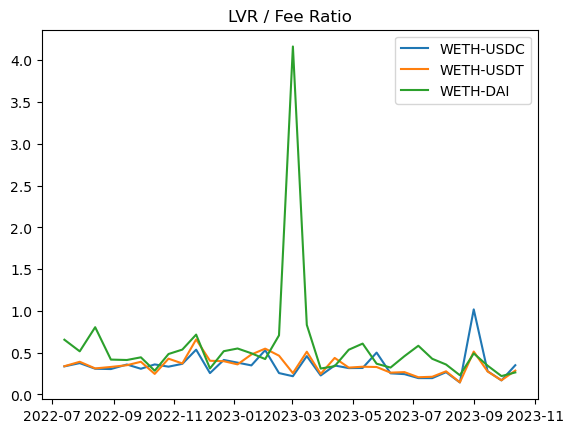

In [27]:
a = df_weth_usdc.loc[:, ['to_timestamp', 'fee_all_in_token0', 'lvr_in_token0', 'token0_in', 'token0_out', 'token1_in', 'token1_out']].assign(
    pool='WETH-USDC',
    ratio=lambda r: r.lvr_in_token0 / r.fee_all_in_token0,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

b = df_weth_usdt.loc[:, ['to_timestamp', 'fee_all_in_token1', 'lvr_in_token1', 'token0_in', 'token0_out', 'token1_in', 'token1_out']].assign(
    pool='WETH-USDT',
    ratio=lambda r: r.lvr_in_token1 / r.fee_all_in_token1,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

c = df_weth_dai.loc[:, ['to_timestamp', 'fee_all_in_token0', 'lvr_in_token0', 'token0_in', 'token0_out', 'token1_in', 'token1_out']].assign(
    pool='WETH-DAI',
    ratio=lambda r: r.lvr_in_token0 / r.fee_all_in_token0,
    to_timestamp=lambda r: pd.to_datetime(r['to_timestamp']))

plt.plot(a['to_timestamp'], a['ratio'], label='WETH-USDC')
plt.plot(b['to_timestamp'], b['ratio'], label='WETH-USDT')
plt.plot(c['to_timestamp'], c['ratio'], label='WETH-DAI')
plt.legend()
plt.title('LVR / Fee Ratio')
plt.show()

In [34]:
a['ratio'].mean(), b['ratio'].mean(), c['ratio'].mean()

(0.34177881004432553, 0.3492907668992511, 0.5801994498332911)

In [35]:
c[c['ratio'] < 4].ratio.mean()

0.46815916802296725

In [36]:
c[c['ratio'] > 4]

,to_timestamp,fee_all_in_token0,lvr_in_token0,token0_in,token0_out,token1_in,token1_out,pool,ratio
16,2023-03-01 10:14:35+00:00,114684.482321,477716.888541,1.995860e+07,-1.826957e+07,10917.610185,-11897.624996,WETH-DAI,4.165488


In [31]:
display(a, b, c)

,to_timestamp,fee_all_in_token0,lvr_in_token0,token0_in,token0_out,token1_in,token1_out,pool,ratio
0,2022-07-13 08:04:00+00:00,3.379354e+06,1.137407e+06,5.451917e+08,-5.812595e+08,518196.616915,-483772.149276,WETH-USDC,0.336575
1,2022-07-28 20:23:09+00:00,4.653297e+06,1.747184e+06,8.328748e+08,-7.182243e+08,508115.600408,-589105.221849,WETH-USDC,0.375472
2,2022-08-13 11:20:57+00:00,3.017404e+06,9.302724e+05,5.230820e+08,-4.827193e+08,282844.725876,-303414.336913,WETH-USDC,0.308302
3,2022-08-29 08:36:50+00:00,2.910638e+06,8.862580e+05,4.529745e+08,-5.172380e+08,307908.631342,-268295.275633,WETH-USDC,0.304489
4,2022-09-14 13:09:44+00:00,3.402326e+06,1.221094e+06,5.787715e+08,-5.553373e+08,344275.177013,-357444.977139,WETH-USDC,0.358900
5,2022-09-28 16:44:23+00:00,3.135053e+06,9.656470e+05,5.051762e+08,-5.398414e+08,395606.839399,-369676.211175,WETH-USDC,0.308016
6,2022-10-12 16:06:11+00:00,1.631302e+06,5.872066e+05,2.702541e+08,-2.735132e+08,206506.851525,-202779.621209,WETH-USDC,0.359962
7,2022-10-26 15:21:47+00:00,1.470143e+06,4.895729e+05,2.709647e+08,-2.190829e+08,165394.619601,-201148.776221,WETH-USDC,0.333010
8,2022-11-09 14:37:59+00:00,3.142376e+06,1.152895e+06,4.970588e+08,-5.503997e+08,378352.383543,-337935.836524,WETH-USDC,0.366886
9,2022-11-23 13:51:59+00:00,3.705012e+06,1.988211e+06,6.117886e+08,-6.232153e+08,517584.610987,-505086.524772,WETH-USDC,0.536627


,to_timestamp,fee_all_in_token1,lvr_in_token1,token0_in,token0_out,token1_in,token1_out,pool,ratio
0,2022-07-13 08:04:00+00:00,9.608570e+05,325222.830231,146412.232786,-138260.189244,1.559641e+08,-1.643216e+08,WETH-USDT,0.338472
1,2022-07-28 20:23:09+00:00,1.700124e+06,665836.510132,184683.670798,-209843.681859,3.011803e+08,-2.655276e+08,WETH-USDT,0.391640
2,2022-08-13 11:20:57+00:00,1.041069e+06,324888.705117,97887.746029,-103973.460166,1.796775e+08,-1.673456e+08,WETH-USDT,0.312072
3,2022-08-29 08:36:50+00:00,1.033011e+06,340607.817462,110053.543682,-94536.758538,1.595418e+08,-1.847951e+08,WETH-USDT,0.329723
4,2022-09-14 13:09:44+00:00,1.060227e+06,371616.002902,107448.808921,-111902.934659,1.806214e+08,-1.727877e+08,WETH-USDT,0.350506
5,2022-09-28 16:44:23+00:00,8.447031e+05,330823.456467,105611.304136,-99014.246165,1.363108e+08,-1.452569e+08,WETH-USDT,0.391645
6,2022-10-12 16:06:11+00:00,3.053467e+05,75220.086953,38978.719771,-37774.865704,5.025196e+07,-5.153026e+07,WETH-USDT,0.246343
7,2022-10-26 15:21:47+00:00,3.480791e+05,149225.167220,38291.449500,-47476.707346,6.478031e+07,-5.124605e+07,WETH-USDT,0.428711
8,2022-11-09 14:37:59+00:00,1.154366e+06,429075.170582,138529.916683,-123495.745338,1.824358e+08,-2.023528e+08,WETH-USDT,0.371698
9,2022-11-23 13:51:59+00:00,1.242067e+06,818751.910749,172162.564161,-168503.180561,2.054637e+08,-2.085588e+08,WETH-USDT,0.659185


,to_timestamp,fee_all_in_token0,lvr_in_token0,token0_in,token0_out,token1_in,token1_out,pool,ratio
0,2022-07-13 08:04:00+00:00,430750.045623,282412.545861,6.941798e+07,-7.416537e+07,65987.510225,-61470.623215,WETH-DAI,0.655630
1,2022-07-28 20:23:09+00:00,557545.929365,288012.598027,9.918042e+07,-8.666823e+07,61805.284779,-70751.803127,WETH-DAI,0.516572
2,2022-08-13 11:20:57+00:00,292551.378034,235644.496254,4.961209e+07,-4.790504e+07,28028.712765,-28758.055277,WETH-DAI,0.805481
3,2022-08-29 08:36:50+00:00,316952.046021,132429.741691,4.829185e+07,-5.735884e+07,34358.485281,-28676.743797,WETH-DAI,0.417823
4,2022-09-14 13:09:44+00:00,358513.236762,148022.229186,6.162927e+07,-5.787515e+07,36164.503782,-38351.244680,WETH-DAI,0.412878
5,2022-09-28 16:44:23+00:00,332718.966412,148007.159581,5.359359e+07,-5.731273e+07,42438.449166,-39591.554907,WETH-DAI,0.444841
6,2022-10-12 16:06:11+00:00,123498.638230,35140.036099,2.028161e+07,-2.088460e+07,15806.400690,-15253.321083,WETH-DAI,0.284538
7,2022-10-26 15:21:47+00:00,142429.203168,69015.395674,2.643335e+07,-2.104305e+07,15820.544081,-19488.332438,WETH-DAI,0.484559
8,2022-11-09 14:37:59+00:00,414040.744233,222509.578899,6.493860e+07,-7.307499e+07,51635.095509,-45309.948624,WETH-DAI,0.537410
9,2022-11-23 13:51:59+00:00,680562.626137,487934.702283,1.119956e+08,-1.148586e+08,95226.346508,-92244.447093,WETH-DAI,0.716958


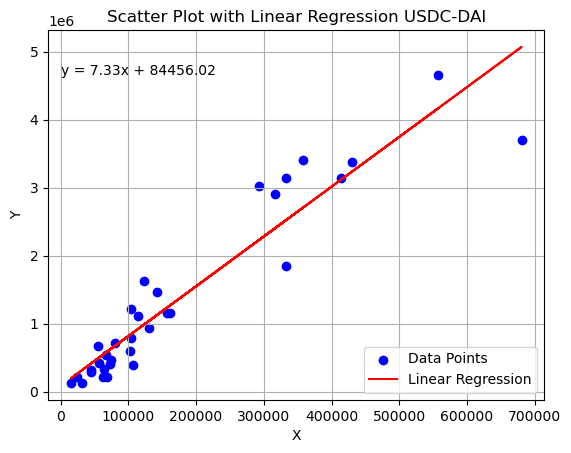

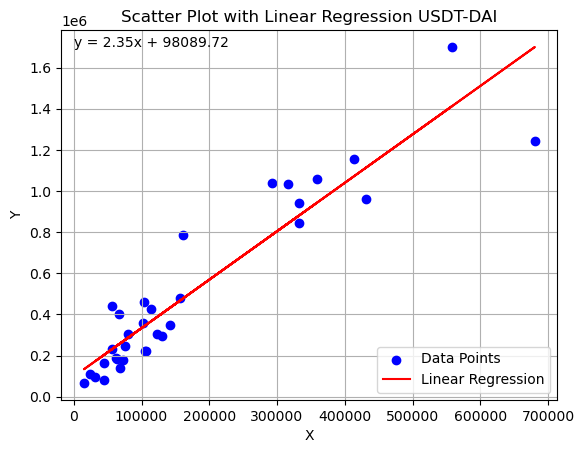

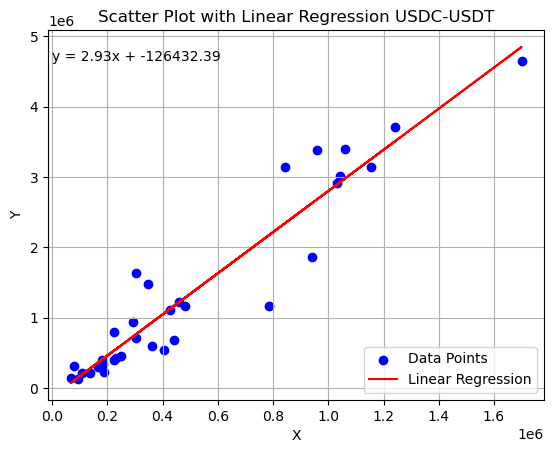

In [41]:
plot_scatter_with_regression(c['fee_all_in_token0'].to_numpy(), a['fee_all_in_token0'].to_numpy(), 'USDC-DAI')
plot_scatter_with_regression(c['fee_all_in_token0'].to_numpy(), b['fee_all_in_token1'].to_numpy(), 'USDT-DAI')
plot_scatter_with_regression(b['fee_all_in_token1'].to_numpy(), a['fee_all_in_token0'].to_numpy(), 'USDC-USDT')